# Import Library

In [31]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Download and Extract Dataset

In [3]:
base_dir = 'image/'


In [4]:
IMAGE_SIZE = [224, 224]
mobile_net = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
for layer in mobile_net.layers:
    layer.trainable = False

In [6]:
folders = glob('image/*')

In [7]:
x = Flatten()(mobile_net.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
os.listdir(base_dir)

['bopeng', 'jerawat', 'komedo']

In [9]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)


In [10]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()


tag
bopeng      936
jerawat    1164
komedo      841
dtype: int64

In [11]:
df.head(10)

,path,file_name,tag
0,image/bopeng\bopeng_0_1005.jpg,bopeng_0_1005.jpg,bopeng
1,image/bopeng\bopeng_0_101.jpg,bopeng_0_101.jpg,bopeng
2,image/bopeng\bopeng_0_1011.jpg,bopeng_0_1011.jpg,bopeng
3,image/bopeng\bopeng_0_1015.jpg,bopeng_0_1015.jpg,bopeng
4,image/bopeng\bopeng_0_1023.jpg,bopeng_0_1023.jpg,bopeng
5,image/bopeng\bopeng_0_1030.jpg,bopeng_0_1030.jpg,bopeng
6,image/bopeng\bopeng_0_1031.jpg,bopeng_0_1031.jpg,bopeng
7,image/bopeng\bopeng_0_1033.jpg,bopeng_0_1033.jpg,bopeng
8,image/bopeng\bopeng_0_1035.jpg,bopeng_0_1035.jpg,bopeng
9,image/bopeng\bopeng_0_1060.jpg,bopeng_0_1060.jpg,bopeng


In [12]:
X = df["path"]
y = df["tag"]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

In [14]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})

In [15]:
print("train size", len(data_train))
print("test size", len(data_test))

train size 2352
test size 589


In [16]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag    
test   bopeng     188
       jerawat    233
       komedo     168
train  bopeng     748
       jerawat    931
       komedo     673
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_24204\3928688440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_test]).reset_index(drop=1)


,path,tag,set
890,image/jerawat\jerawat_0_915.jpg,jerawat,train
267,image/bopeng\bopeng_0_1151.jpg,bopeng,train
756,image/jerawat\jerawat_0_2254.jpg,jerawat,train


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)


In [18]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

Found 2352 validated image filenames belonging to 3 classes.
Found 589 validated image filenames belonging to 3 classes.


# Building Model

In [19]:
model = Model(inputs=mobile_net.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [21]:
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [22]:
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=5,
      validation_data=test_generator,
      validation_steps=len(test_generator),
)


Epoch 1/5
74/74 [==============================] - 167s 2s/step - loss: 0.8338 - accuracy: 0.9171 - val_loss: 0.0898 - val_accuracy: 0.9830
Epoch 2/5
74/74 [==============================] - 122s 2s/step - loss: 0.0844 - accuracy: 0.9830 - val_loss: 0.0548 - val_accuracy: 0.9881
Epoch 3/5
74/74 [==============================] - 119s 2s/step - loss: 0.1311 - accuracy: 0.9826 - val_loss: 0.7128 - val_accuracy: 0.9219
Epoch 4/5
74/74 [==============================] - 109s 1s/step - loss: 0.2423 - accuracy: 0.9745 - val_loss: 0.1236 - val_accuracy: 0.9847
Epoch 5/5
74/74 [==============================] - 106s 1s/step - loss: 0.1855 - accuracy: 0.9821 - val_loss: 0.0634 - val_accuracy: 0.9915


# Model Accuracy

In [23]:
test_loss, test_acc = model.evaluate(test_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


19/19 [==============================] - 25s 1s/step - loss: 0.0029 - accuracy: 1.0000

accuracy: 1.0   loss:  0.002907205605879426


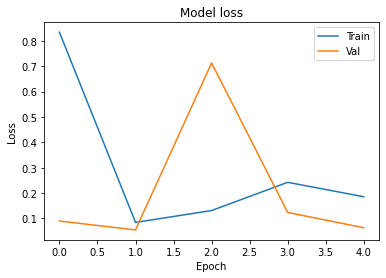

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

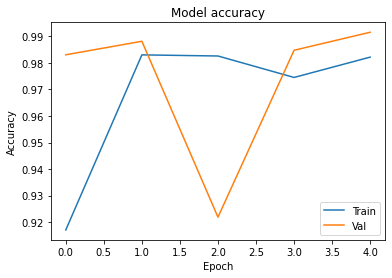

In [25]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Making Prediction

[2]
[2]
[1]
[1]
[1]
[1]
[2]
[2]
[1]
[2]
[1]
[2]
[1]
[1]
[2]
[1]
[2]
[1]
[2]
[1]
[1]
[1]
[2]
[2]
[1]


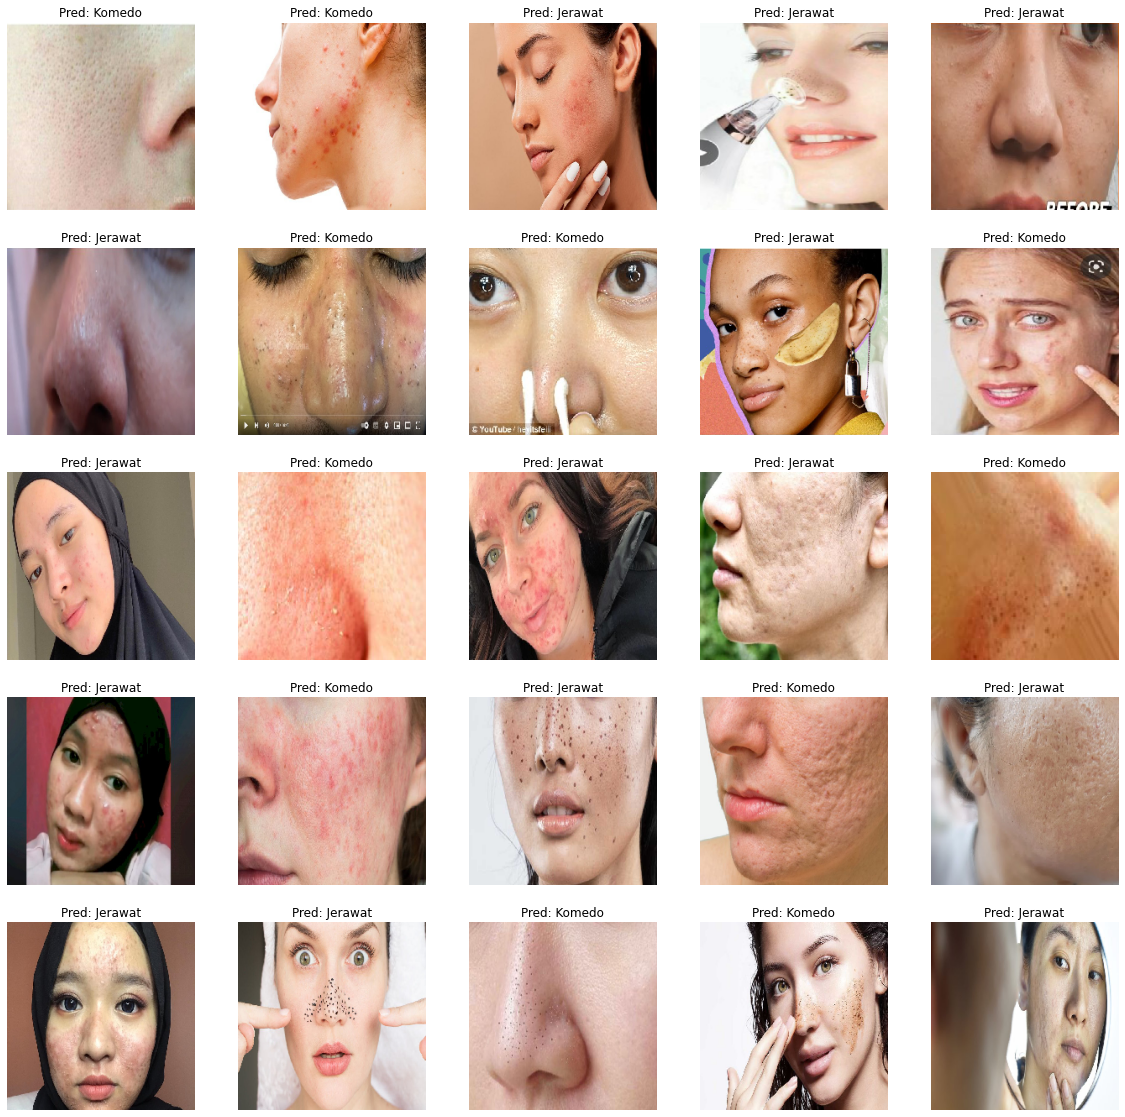

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

m = 1
columns = 5
rows = 5
directory = 'test'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        classes = np.argmax(classes, axis=1)
        print(classes)
        if classes==0:
            pred_labels = 'Bopeng'
        elif classes==1:
            pred_labels = 'Jerawat'
        else:
            pred_labels = 'Komedo'
            
        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.axis('Off')
        plt.title("Pred: " + pred_labels)
        m += 1

# Model Evaluation

In [33]:
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred, 0)

In [34]:
y_pred

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [35]:
y_pred_labels = []

for value in range(len(y_pred)):
    if y_pred[value, 0] != 0:
        y_pred_labels.append(0)
    elif y_pred[value, 1] != 0:
        y_pred_labels.append(1)
    else:
        y_pred_labels.append(2)

y_pred_labels

[2,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 2,


In [37]:
y_test.replace(['bopeng', 'jerawat', 'komedo'], [0, 1, 2], inplace=True)
y_test

119     0
2138    2
871     0
774     0
2484    2
       ..
1673    1
2791    2
599     0
816     0
1205    1
Name: tag, Length: 589, dtype: int64

In [39]:
cf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_df = pd.DataFrame(
    cf_matrix,
    index=["Bopeng", "Jerawat", "Komedo"],
    columns=["Bopeng", "Jerawat", "Komedo"]
)

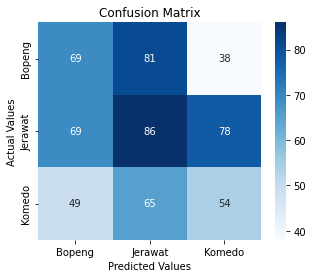

In [40]:
import seaborn as sns

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Save the Model

In [30]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "ausion_project"
SAVE_MODEL_NAME = "ausion.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print("Saving Model At {}...".format(save_model_path))
model.save(save_model_path, include_optimizer=False)


Saving Model At model\ausion_project\ausion.h5...
